<a href="https://colab.research.google.com/github/v1t3ls0n/ml_intro_course_mmn11/blob/main/notebooks/mmn11_notebook_guy_vitelson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maman 11 by Guy Vitelson (aka @v1t3ls0n on GitHub)
#### If you run this within Google Collab, Dont Worry! all the missing python files/directories/modules will be automatically feteched from my github
#### https://github.com/v1t3ls0n/ml_intro_course_mmn11


# Overview



## MNIST Digit Classification Using Perceptron Learning Algorithm (PLA)

**Objective:**  
This notebook compares the performance of two variants of the Perceptron Learning Algorithm (PLA) on the MNIST digit classification task:
- **Clean PLA:** Standard perceptron without enhancements.
- **Pocket PLA:** Enhanced perceptron that stores the best-performing weights during training (using the Pocket algorithm).

**Dataset:**  
- MNIST dataset consisting of 60,000 training samples and 10,000 test samples.
- The images are normalized to the range [0, 1] and a bias term is added, resulting in input samples with 785 features.

**Evaluation Metrics:**  
- **Confusion Matrices:** Provides a detailed view of how well each digit is classified.
- **Overall Accuracy (ACC):** Defined as \(\text{ACC} = \frac{TP + TN}{TP + TN + FP + FN}\).
- **Sensitivity (True Positive Rate, TPR):** For each digit, calculated as \(\text{TPR} = \frac{TP}{TP + FN}\), showing the model’s ability to correctly identify the digit.
- **Selectivity (Specificity, TNR):** For each digit, calculated as \(\text{TNR} = \frac{TN}{TN + FP}\), showing the model’s ability to correctly identify negatives.
- **Training and Testing Error Curves:** Visualized as a function of iteration for detailed analysis of learning dynamics.
- **Runtime:** The time taken to train the models.

**Goals:**  
- Evaluate and compare the model accuracy and robustness between Clean PLA and Pocket PLA.
- Analyze and visualize the performance through confusion matrices, error curves, and summary plots (accuracy, sensitivity, selectivity, and runtime vs. the number of iterations).
- Provide a comprehensive discussion on how training iterations affect the decision boundaries and the overall performance, particularly in the one-vs-all classification setup.

This notebook integrates detailed quantitative evaluation with comprehensive visualizations to thoroughly analyze the multi-class Perceptron performance on the MNIST dataset.

# Imports

## External Code Imports (pip packages)

In [1]:
#
import os
import shutil
import sys
import logging
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore



## Fetch Missing Files For Google Colab Env

In [2]:


if sys.platform != 'win32': # check if we are running on google collab
  repo_url = "https://github.com/v1t3ls0n/ml_intro_course_mmn11"
  repo_name = "ml_intro_course_mmn11"
  from tqdm.notebook import tqdm


  # Clone the repository if it doesn't exist
  if not os.path.exists(repo_name):
    os.system(f"git clone {repo_url}")

  # Construct the path to the repository directory
  repo_path = os.path.join(os.getcwd(), repo_name)

  # Add the repository directory to the Python path
  if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

  # --- Extract 'core' and 'notebooks' directories ---
  def extract_directories(source_dir, destination_dir, dir_names):
      for dir_name in dir_names:
          source_path = os.path.join(source_dir, dir_name)
          destination_path = os.path.join(destination_dir, dir_name)
          if os.path.exists(source_path):
              shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

  destination_path = "."
  # Extract the directories
  extract_directories(repo_path, destination_path, ["core", "notebooks"])
  project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
  sys.path.insert(0, project_root)
  if os.path.exists("ml_intro_course_mmn11"):
    shutil.rmtree("ml_intro_course_mmn11")
    print(f"Deleted ml_intro_course_mmn11")

else:
  from tqdm import tqdm # type: ignore
  %%capture run_output
  %matplotlib inline

## Internal Code Imports (original code)

In [3]:
# Data Preprocessing:
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data

# Models (Multi-Class Perceptron, Softmax Regression):
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron

# Performance Evaluation, Analysis and Plotting:
from core.analysis.evaluation_functions import evaluate_model
from core.analysis.plotting import plot_error_curves, plot_performance_summary,plot_accuracy_vs_max_iter,plot_runtime_vs_max_iter,plot_performance_summary_extended

logger = logging.getLogger("MyGlobalLogger") # configured in core/logger/coifg.py


#1. Load and Preprocess the MNIST Dataset

We'll load the MNIST dataset using our custom loader (`mnist_loader`) and then apply preprocessing (`data_preprocessing`). The preprocessing step normalizes each image to the range [0, 1] and adds a bias term, resulting in input samples with 785 features. This setup ensures that the training set contains 60,000 samples and the test set 10,000 samples, preparing the data for the subsequent classification tasks.# New section

In [4]:

# Load raw MNIST data (X: images, y: labels)
X_raw, y_raw = load_mnist()


logger.info("Raw MNIST data shapes: X_raw: %s, y_raw: %s", X_raw.shape, y_raw.shape)

# Preprocess (normalize & add bias = True)
X = preprocess_data(X_raw, add_bias=True, normalize=True)
logger.info("Preprocessed shape: %s", X.shape)

# Split into train/test manually or with 60k/10k as the task suggests
X_train, y_train = X[:60000], y_raw[:60000]
X_test,  y_test  = X[60000:], y_raw[60000:]

logger.info("Train set: X_train: %s, y_train: %s", X_train.shape, y_train.shape)
logger.info("Test set: X_test: %s, y_test: %s", X_test.shape, y_test.shape)



2025-03-12 21:57:35,786 - INFO - Raw MNIST data shapes: X_raw: (70000, 784), y_raw: (70000,)
2025-03-12 21:57:36,167 - INFO - Preprocessed shape: (70000, 785)
2025-03-12 21:57:36,168 - INFO - Train set: X_train: (60000, 785), y_train: (60000,)
2025-03-12 21:57:36,170 - INFO - Test set: X_test: (10000, 785), y_test: (10000,)


# Train, Evaluate, and Visualize Training Results

This section trains, evaluates, and visualizes the performance of **Clean PLA** and **Pocket PLA** across multiple values of `max_iter`.

### **Training and Evaluation Steps:**

1. **Train Models for Different Iterations (`max_iter`):**  
   - Train **Clean PLA** (standard Perceptron) and **Pocket PLA** (best-weight tracking variant) in a one-vs-all setup.
   - Each digit is handled by a separate binary classifier with batch updates on all misclassified samples.
   - Trained models are stored for later analysis.

2. **Assess Model Performance:**  
   - **Confusion Matrices:** Generate annotated confusion matrices to inspect per-class predictions.
   - **Overall Accuracy (ACC):** Calculate accuracy as \(\text{ACC} = \frac{TP + TN}{TP + TN + FP + FN}\).
   - **Sensitivity (TPR):** For each digit, compute \(\text{TPR} = \frac{TP}{TP + FN}\).
   - **Selectivity (TNR):** For each digit, compute \(\text{TNR} = \frac{TN}{TN + FP}\).
   - **Runtime:** Record the training time.

3. **Performance Visualization:**  
   - Plot **Accuracy vs. Max Iterations** to observe the effect of iteration count on accuracy.
   - Plot **Runtime vs. Max Iterations** to examine computational efficiency.
   - Generate an extended summary plot combining Accuracy, Sensitivity (TPR), Selectivity (TNR), and Runtime vs. `max_iter`.
   - Plot **Training Error Curves** for Each digit-specific classifier within the MultiClassPerceptron stores iteration-level training errors. We aggregate these losses across all digit classifiers to create an average training error curve. This provides a high-level overview of how the algorithm's error evolves over time for both Clean and Pocket PLA.

📌 **Goal:**  
Understand how the iteration count (`max_iter`) impacts accuracy, sensitivity, selectivity, and runtime. This analysis helps in selecting an optimal trade-off between training efficiency and performance.


  0%|          | 0/3 [00:00<?, ?it/s]

2025-03-12 21:57:36,205 - INFO - === Training PLA Clean Model (Without Using Pocket Algorithm) with max_iter=10 ===
2025-03-12 21:57:36,206 - INFO - Training binary classifier for digit 0...
2025-03-12 21:57:37,704 - INFO - Training binary classifier for digit 1...
2025-03-12 21:57:39,858 - INFO - Training binary classifier for digit 2...
2025-03-12 21:57:41,678 - INFO - Training binary classifier for digit 3...
2025-03-12 21:57:44,119 - INFO - Training binary classifier for digit 4...
2025-03-12 21:57:45,731 - INFO - Training binary classifier for digit 5...
2025-03-12 21:57:47,338 - INFO - Training binary classifier for digit 6...
2025-03-12 21:57:48,979 - INFO - Training binary classifier for digit 7...
2025-03-12 21:57:50,609 - INFO - Training binary classifier for digit 8...
2025-03-12 21:57:52,895 - INFO - Training binary classifier for digit 9...
2025-03-12 21:57:54,700 - INFO - Training binary classifier for digit 0...
2025-03-12 21:57:56,236 - INFO - Training binary classifier

  0%|          | 0/3 [00:00<?, ?it/s]

2025-03-12 22:01:07,841 - INFO - === Evaluating PLA With Pocket Model With max_iter=10 ===
2025-03-12 22:01:07,894 - INFO - Built-in Confusion Matrix:
[[908   0   4   2   0   2  16   1  47   0]
 [  0 898   4   2   0   0   5   0 226   0]
 [ 18   1 797  29  16   0  29   7 135   0]
 [  6   0  23 795   0  19   9   7 149   2]
 [  5   0   6   1 823   0  24   1 113   9]
 [ 26   2  10 102  11 470  20   7 241   3]
 [ 24   2  25   1  11  14 837   0  44   0]
 [  9  10  19   0  17   0   1 857 107   8]
 [  5   0   3  20   5   2   6   5 928   0]
 [ 13   1  15  10 271   6   4  85 263 341]]
2025-03-12 22:01:07,895 - INFO - Overall Accuracy: 76.54%
2025-03-12 22:01:07,896 - INFO - Sensitivity (TPR) for class '0': 0.93
2025-03-12 22:01:07,897 - INFO - Selectivity (TNR) for class '0': 0.99
2025-03-12 22:01:07,898 - INFO - Sensitivity (TPR) for class '1': 0.79
2025-03-12 22:01:07,898 - INFO - Selectivity (TNR) for class '1': 1.00
2025-03-12 22:01:07,900 - INFO - Sensitivity (TPR) for class '2': 0.77
2025-

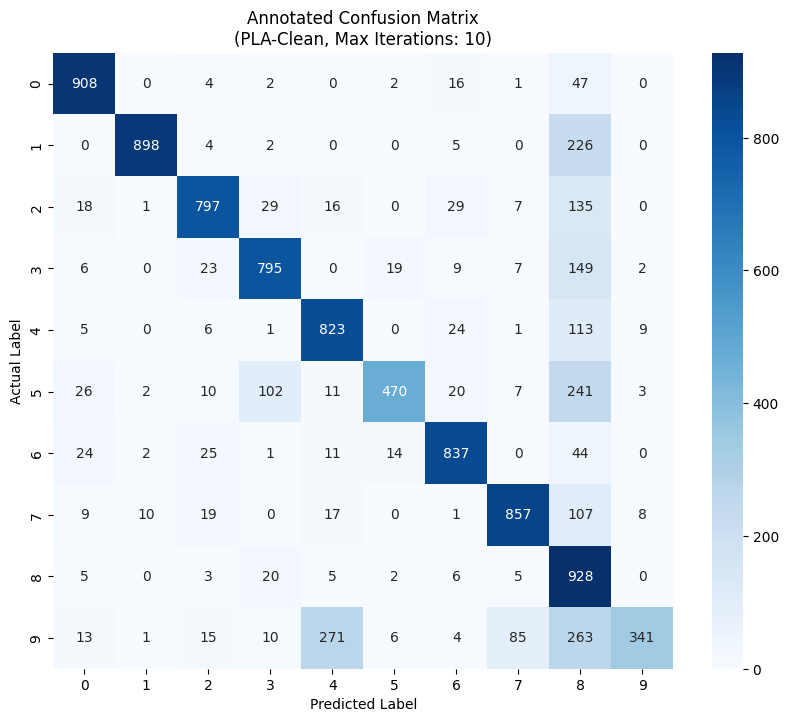

2025-03-12 22:01:08,478 - INFO - Built-in Confusion Matrix:
[[889   0  11   8   0  32  29   1  10   0]
 [  0 982  45  19   0   2   6   0  81   0]
 [ 15   1 880  44  13   0  30  13  36   0]
 [  5   0  32 881   0  29   9  14  36   4]
 [  3   3  10   6 852   4  40   4  33  27]
 [ 19   3  33 124  16 615  27  11  41   3]
 [ 21   3  33   2   8  23 860   0   8   0]
 [  8  16  47   1  14   0   1 906  22  13]
 [  3   1  28 102  10  33  13  17 764   3]
 [ 13   3  20  21 229  29   5 118  52 519]]
2025-03-12 22:01:08,483 - INFO - Overall Accuracy: 81.48%
2025-03-12 22:01:08,484 - INFO - Sensitivity (TPR) for class '0': 0.91
2025-03-12 22:01:08,485 - INFO - Selectivity (TNR) for class '0': 0.99
2025-03-12 22:01:08,486 - INFO - Sensitivity (TPR) for class '1': 0.87
2025-03-12 22:01:08,487 - INFO - Selectivity (TNR) for class '1': 1.00
2025-03-12 22:01:08,488 - INFO - Sensitivity (TPR) for class '2': 0.85
2025-03-12 22:01:08,492 - INFO - Selectivity (TNR) for class '2': 0.97
2025-03-12 22:01:08,493 -

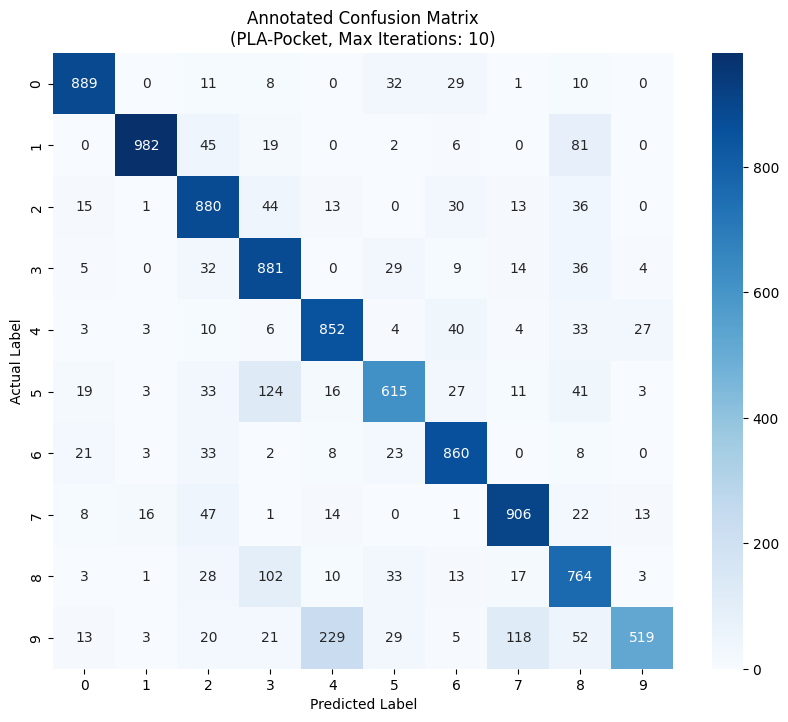

2025-03-12 22:01:09,150 - INFO - Evaluation complete for PLA With Pocket Model With max_iter=10
2025-03-12 22:01:09,152 - INFO - === Evaluating PLA With Pocket Model With max_iter=20 ===
2025-03-12 22:01:09,223 - INFO - Built-in Confusion Matrix:
[[ 941    0    4    4    0   19   11    1    0    0]
 [   0 1066   31   17    1   16    4    0    0    0]
 [  20    6  899   38   19    5   26   17    2    0]
 [   8    1   31  901    1   40    7   19    0    2]
 [   4    7    8    3  908   15   23    5    2    7]
 [  33    6   13   73   19  716   21    8    0    3]
 [  22    5   14    2   10   26  879    0    0    0]
 [   7   23   49    6   10    1    4  923    0    5]
 [  12   17   93  181   14  471   25   32  121    8]
 [  18    9   27   22  293   80    5  174    0  381]]
2025-03-12 22:01:09,224 - INFO - Overall Accuracy: 77.35%
2025-03-12 22:01:09,228 - INFO - Sensitivity (TPR) for class '0': 0.96
2025-03-12 22:01:09,229 - INFO - Selectivity (TNR) for class '0': 0.99
2025-03-12 22:01:09,23

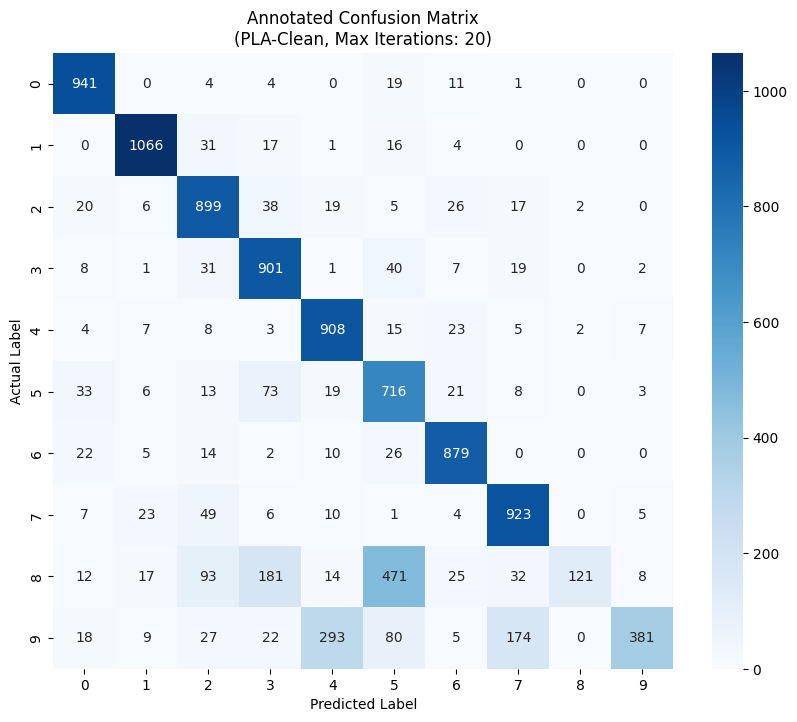

2025-03-12 22:01:10,075 - INFO - Built-in Confusion Matrix:
[[ 940    0    4    4    0   13   11    1    7    0]
 [   0 1062   19   14    1   14    4    0   21    0]
 [  20    6  880   33   19    2   26   17   29    0]
 [   8    1   28  895    1   38    7   17   13    2]
 [   4    6    7    4  903   15   23    5   12    3]
 [  33    6    9   73   17  696   19    8   29    2]
 [  22    4   14    2   10   25  876    0    5    0]
 [   7   23   46    7   10    0    4  921    5    5]
 [   9    5   24   72    5   68   16   17  758    0]
 [  19    8   27   19  237   75    4  138   36  446]]
2025-03-12 22:01:10,079 - INFO - Overall Accuracy: 83.77%
2025-03-12 22:01:10,081 - INFO - Sensitivity (TPR) for class '0': 0.96
2025-03-12 22:01:10,083 - INFO - Selectivity (TNR) for class '0': 0.99
2025-03-12 22:01:10,084 - INFO - Sensitivity (TPR) for class '1': 0.94
2025-03-12 22:01:10,087 - INFO - Selectivity (TNR) for class '1': 0.99
2025-03-12 22:01:10,089 - INFO - Sensitivity (TPR) for class '2': 0

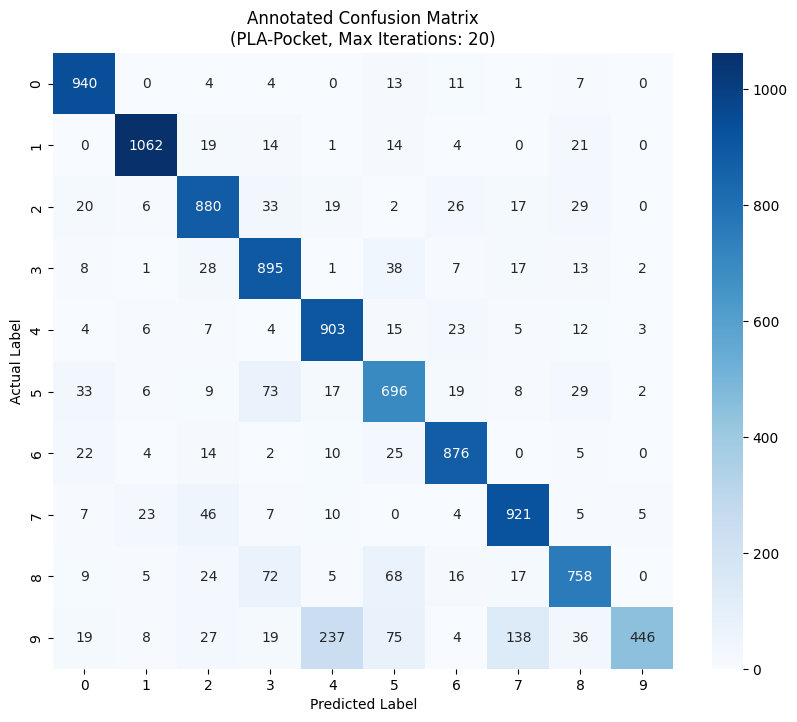

2025-03-12 22:01:10,746 - INFO - Evaluation complete for PLA With Pocket Model With max_iter=20
2025-03-12 22:01:10,748 - INFO - === Evaluating PLA With Pocket Model With max_iter=50 ===
2025-03-12 22:01:10,812 - INFO - Built-in Confusion Matrix:
[[ 959    0    3    6    1    0    7    1    3    0]
 [   0 1077   18   23    1    0    4    2   10    0]
 [   9    7  912   26   16    0   20   20   19    3]
 [   6    0   20  955    1    4    4   13    6    1]
 [   1    0    8    7  933    0   14    2    4   13]
 [  33    6   15  169   42  526   27   18   45   11]
 [  19    3    9    7   11    3  905    0    1    0]
 [   6   13   44   13    9    0    2  936    0    5]
 [  18    7   39  137   18    8   18   23  704    2]
 [  13    8   23   47  174    5    0   98    3  638]]
2025-03-12 22:01:10,816 - INFO - Overall Accuracy: 85.45%
2025-03-12 22:01:10,817 - INFO - Sensitivity (TPR) for class '0': 0.98
2025-03-12 22:01:10,818 - INFO - Selectivity (TNR) for class '0': 0.99
2025-03-12 22:01:10,81

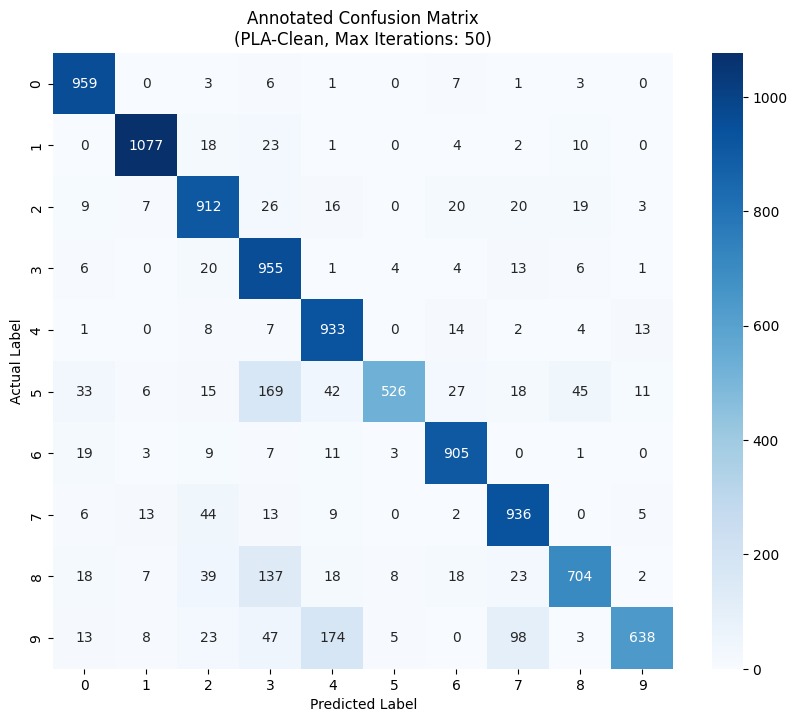

2025-03-12 22:01:11,603 - INFO - Built-in Confusion Matrix:
[[ 956    0    3    3    1    0    6    1   10    0]
 [   0 1075   14   18    1    2    4    1   20    0]
 [   9    5  901   21   15    0   18   18   42    3]
 [   6    0   20  928    1   17    4   12   21    1]
 [   1    0    8    6  924    1   13    2   13   14]
 [  20    4    9   88   20  653   20   10   64    4]
 [  16    3    7    5   11   12  892    0   12    0]
 [   5   12   44   11    8    0    2  934    5    7]
 [  11    3   19   58    7   16    9   14  837    0]
 [  12    7   21   31  149   17    0   83   36  653]]
2025-03-12 22:01:11,604 - INFO - Overall Accuracy: 87.53%
2025-03-12 22:01:11,612 - INFO - Sensitivity (TPR) for class '0': 0.98
2025-03-12 22:01:11,614 - INFO - Selectivity (TNR) for class '0': 0.99
2025-03-12 22:01:11,616 - INFO - Sensitivity (TPR) for class '1': 0.95
2025-03-12 22:01:11,617 - INFO - Selectivity (TNR) for class '1': 1.00
2025-03-12 22:01:11,619 - INFO - Sensitivity (TPR) for class '2': 0

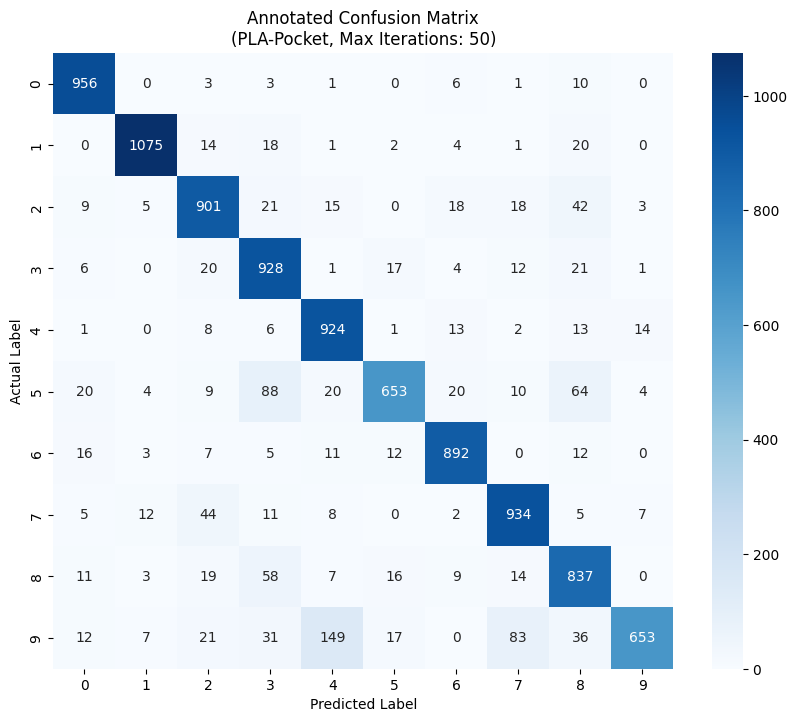

2025-03-12 22:01:12,142 - INFO - Evaluation complete for PLA With Pocket Model With max_iter=50
2025-03-12 22:01:12,146 - INFO - === Plotting Average Training Curves for Clean vs Pocket PLA ===


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

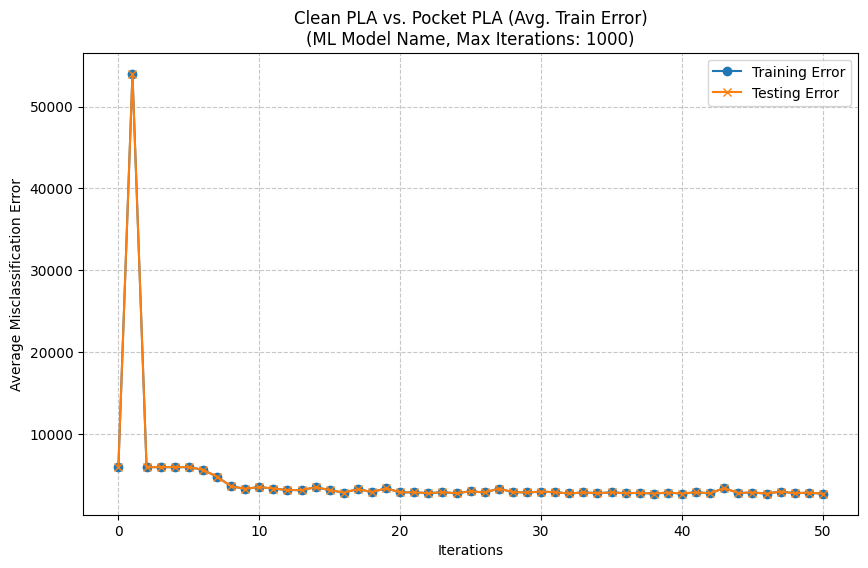

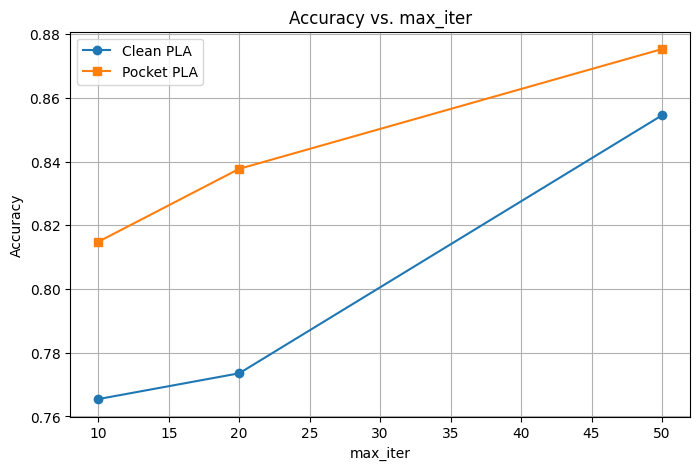

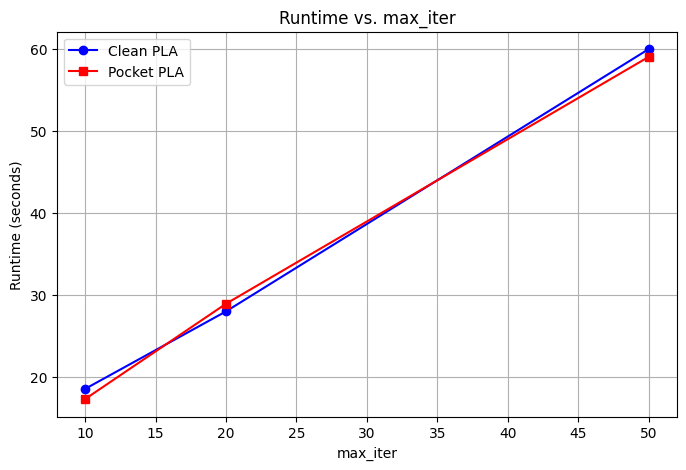

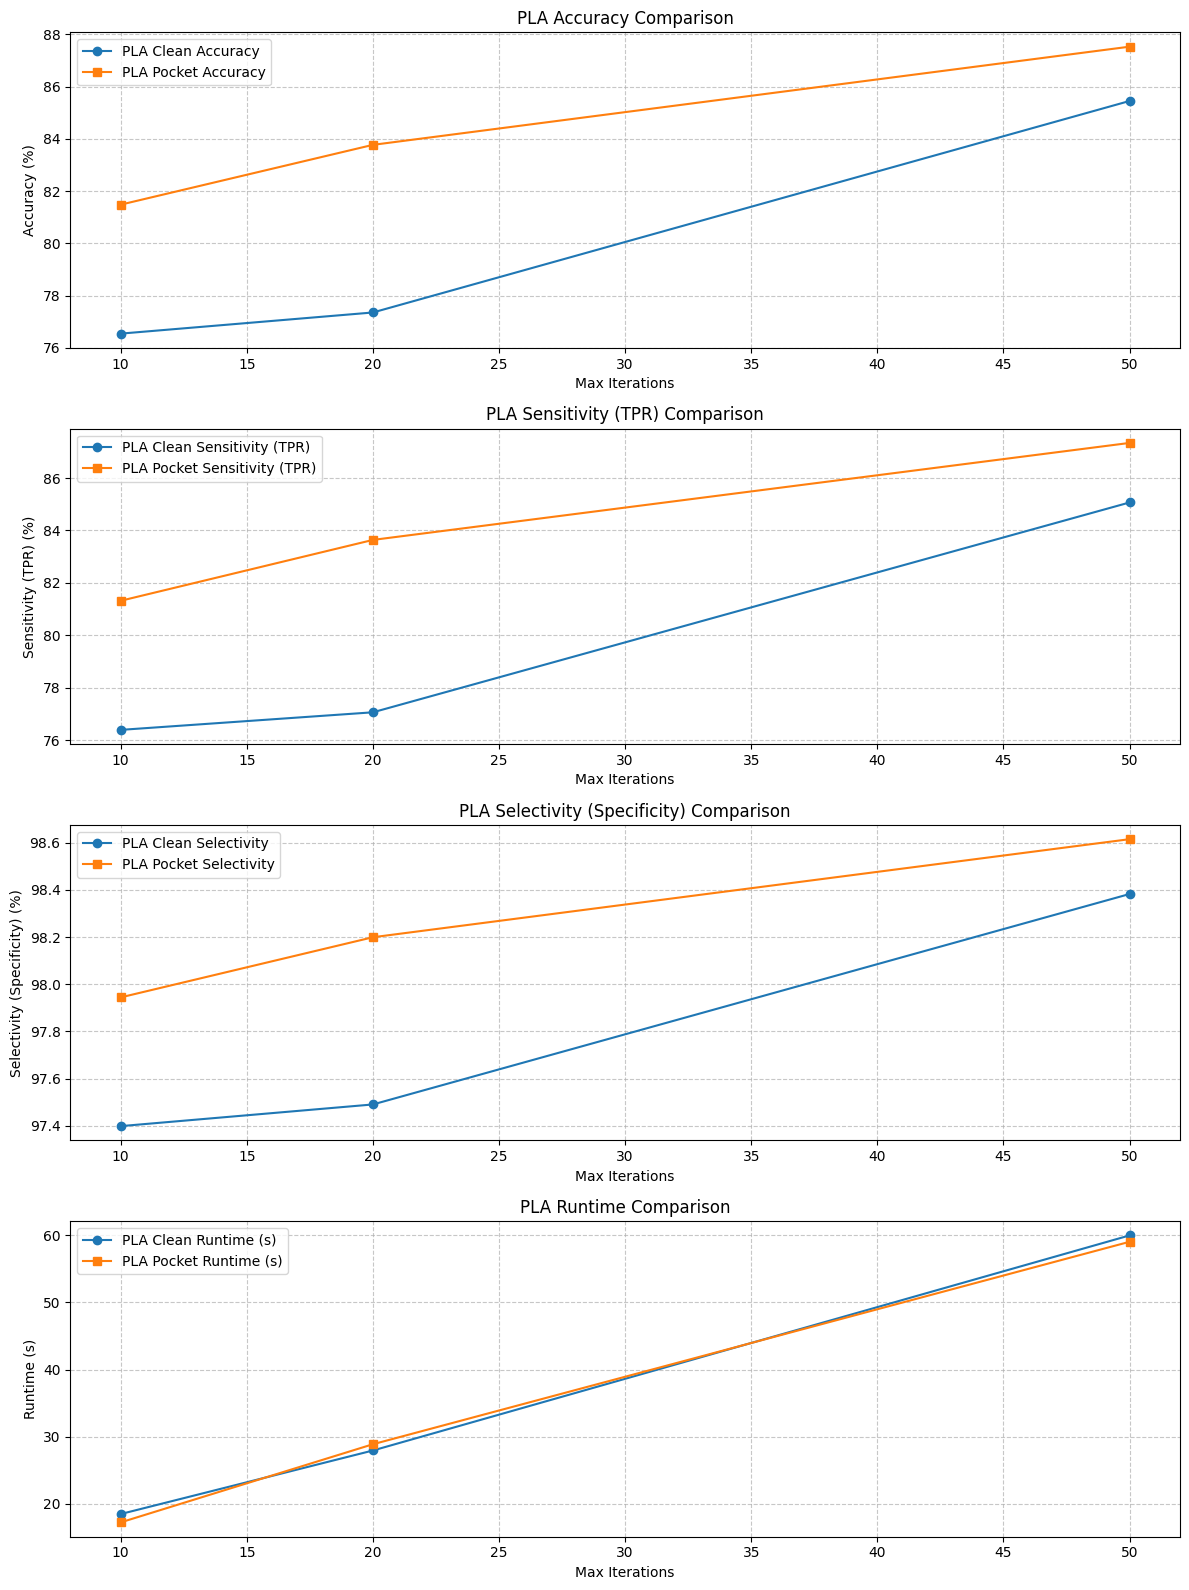

2025-03-12 22:01:14,347 - INFO - Plotted accuracy, sensitivity, selectivity, and runtime vs. max_iter.
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_

In [5]:
## 2. Train, Evaluate, and Visualize Training Results


max_iter_values = [10,20,50]

# Dictionaries to store trained models
trained_models_clean = {}
trained_models_pocket = {}

# Lists to store accuracy, runtime, sensitivity, and selectivity results
accuracies_clean = []
accuracies_pocket = []
runtimes_clean = []
runtimes_pocket = []
sensitivities_clean = []
sensitivities_pocket = []
selectivities_clean = []
selectivities_pocket = []

# ========== Train Clean and Pocket PLA for different max_iter values ==========
for max_iter in tqdm(max_iter_values):
    logger.info(f"=== Training PLA Clean Model (Without Using Pocket Algorithm) with max_iter={max_iter} ===")

    # Train Clean PLA
    clean_perceptron = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=False)
    clean_perceptron.fit(X_train, y_train)
    trained_models_clean[max_iter] = clean_perceptron

    # Train Pocket PLA
    pocket_perceptron = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=True)
    pocket_perceptron.fit(X_train, y_train)
    trained_models_pocket[max_iter] = pocket_perceptron

    logger.info(f"Training complete for PLA Clean Model With max_iter={max_iter}")

# ========== Evaluate Models ==========
for max_iter in tqdm(max_iter_values):
    logger.info(f"=== Evaluating PLA With Pocket Model With max_iter={max_iter} ===")

    # Retrieve trained models
    clean_perceptron = trained_models_clean[max_iter]
    pocket_perceptron = trained_models_pocket[max_iter]

    # Evaluate Clean PLA
    cm_clean, acc_clean, sens_clean, spec_clean, runtime_clean = evaluate_model(
        clean_perceptron, X_test, y_test, classes=list(range(10)),model_name="clean PLA"
    )
    accuracies_clean.append(acc_clean)
    sensitivities_clean.append(np.mean(sens_clean))   # Mean sensitivity for reporting
    selectivities_clean.append(np.mean(spec_clean))     # Mean selectivity for reporting
    runtimes_clean.append(runtime_clean)

    # Evaluate Pocket PLA
    cm_pocket, acc_pocket, sens_pocket, spec_pocket, runtime_pocket = evaluate_model(
        pocket_perceptron, X_test, y_test, classes=list(range(10)), model_name="pocket PLA"
    )
    accuracies_pocket.append(acc_pocket)
    sensitivities_pocket.append(np.mean(sens_pocket))   # Mean sensitivity for reporting
    selectivities_pocket.append(np.mean(spec_pocket))     # Mean selectivity for reporting
    runtimes_pocket.append(runtime_pocket)

    logger.info(f"Evaluation complete for PLA With Pocket Model With max_iter={max_iter}")



## Visualize Training Error Curves
# Function to aggregate loss curves across iterations
def aggregate_iteration_losses(mcp_list):
    """
    Aggregates iteration-level train/test losses across all digits
    into an overall 'train_curve' by averaging across tested models.
    """
    num_classes = mcp_list[0].num_classes  # Assume all models have the same num_classes

    # Determine the maximum number of iterations across all models
    max_len = max(max(len(mcp.loss_history[cls_idx]["train"]) for cls_idx in range(num_classes)) for mcp in mcp_list)

    all_train_curves = []

    for mcp in tqdm(mcp_list):
        all_train = []
        for cls_idx in tqdm(range(num_classes)):
            t_arr = mcp.loss_history[cls_idx]["train"][:]

            # If classifier converged early, pad with last value
            if len(t_arr) < max_len:
                t_arr += [t_arr[-1]] * (max_len - len(t_arr))

            all_train.append(t_arr)

        # Convert to NumPy array and compute mean curve
        all_train = np.array(all_train)
        train_curve = np.mean(all_train, axis=0)

        all_train_curves.append(train_curve)

    # Convert all train curves into a uniform NumPy array
    all_train_curves = np.array(all_train_curves)

    return np.mean(all_train_curves, axis=0)  # Final averaged curve


logger.info("=== Plotting Average Training Curves for Clean vs Pocket PLA ===")

# Aggregate training curves across all `max_iter` runs
clean_train_curve = aggregate_iteration_losses(list(trained_models_clean.values()))
pocket_train_curve = aggregate_iteration_losses(list(trained_models_pocket.values()))

plot_error_curves(
    train_curve=clean_train_curve,
    test_curve=pocket_train_curve,
    title="Clean PLA vs. Pocket PLA (Avg. Train Error)")

# ========== Summary Plots ==========
# Plot accuracy vs. max_iter
plot_accuracy_vs_max_iter(
    max_iter_values,
    accuracies_clean,
    accuracies_pocket,
)

# Plot runtime vs. max_iter
plot_runtime_vs_max_iter(
    max_iter_values,
    runtimes_clean,
    runtimes_pocket,
)

# Plot comprehensive summary: Accuracy, Sensitivity (TPR), Selectivity (TNR), and Runtime vs. max_iter
plot_performance_summary_extended(
    max_iter_values,
    accuracies_clean, accuracies_pocket,
    sensitivities_clean, sensitivities_pocket,
    selectivities_clean, selectivities_pocket,
    runtimes_clean, runtimes_pocket,
)

logger.info("Plotted accuracy, sensitivity, selectivity, and runtime vs. max_iter.")

# print out a summary of the metrics:
logger.info("Mean Sensitivity (TPR) for Clean PLA: %s", sensitivities_clean)
logger.info("Mean Sensitivity (TPR) for Pocket PLA: %s", sensitivities_pocket)
logger.info("Mean Selectivity (TNR) for Clean PLA: %s", selectivities_clean)
logger.info("Mean Selectivity (TNR) for Pocket PLA: %s", selectivities_pocket)


# Summary of Performance Across Iterations

This section provides a comprehensive comparison of Clean PLA and Pocket PLA across multiple iteration settings (`max_iter`). The performance summary includes:
- **Overall Accuracy (%):** Measures the classification success rate.
- **Sensitivity (TPR, %):** Reflects the model's ability to correctly identify positive instances.
- **Selectivity (TNR, %):** Assesses how well the model identifies negatives.
- **Training Runtime (seconds):** Evaluates computational efficiency.

By analyzing these results, we can assess the trade-off between accuracy improvements and increased training time as `max_iter` increases, guiding optimal hyperparameter selection.


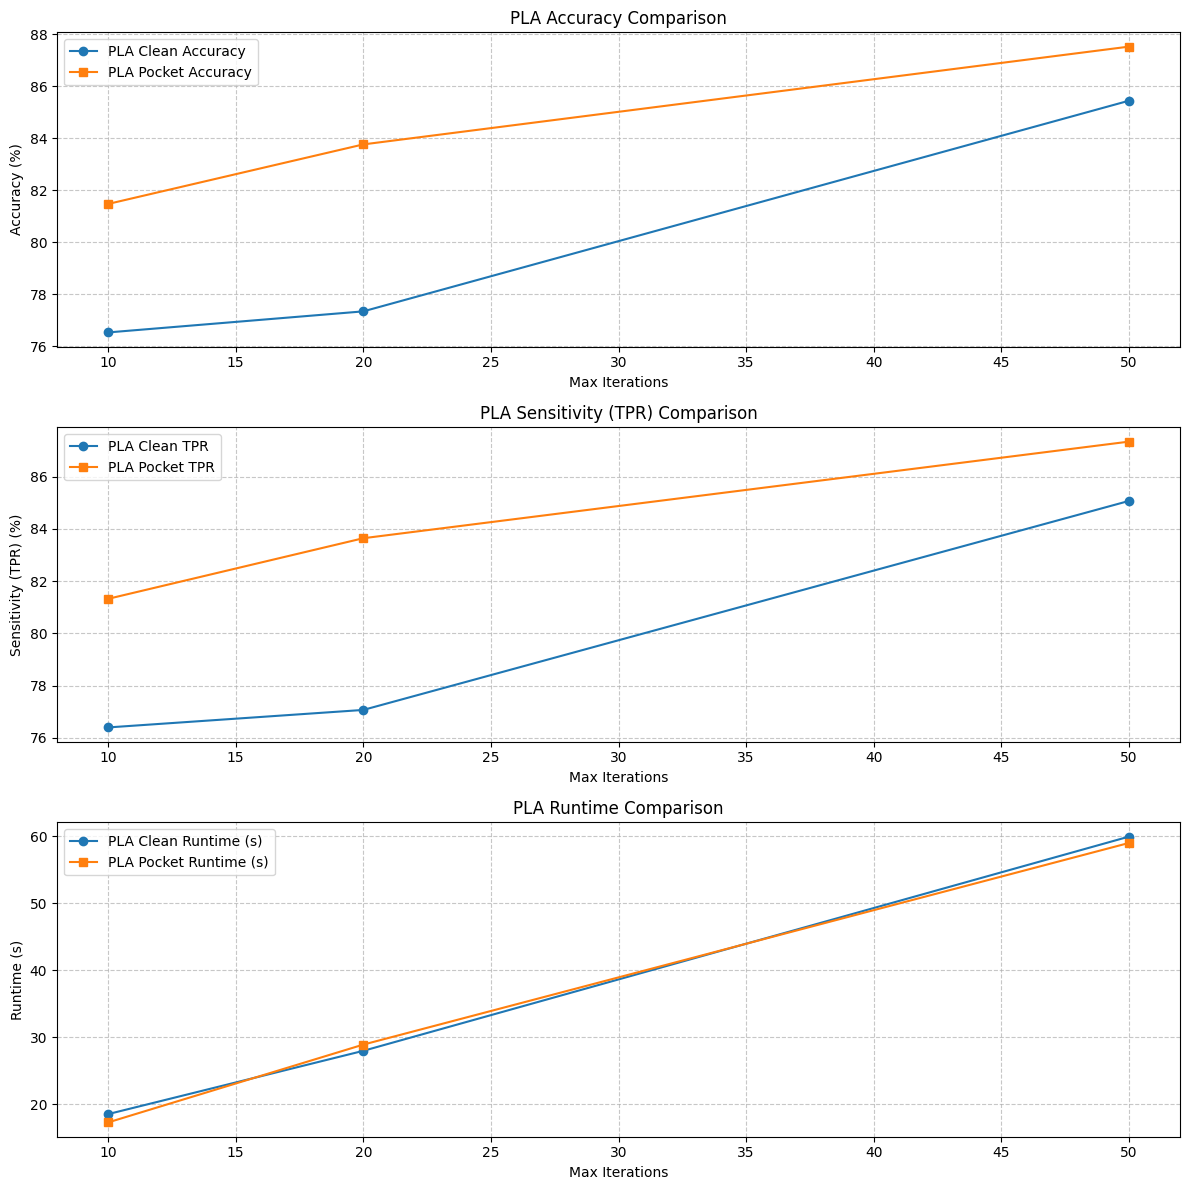

In [6]:
# Generate performance plots
plot_performance_summary(max_iter_values, accuracies_clean, accuracies_pocket,
                         sensitivities_clean, sensitivities_pocket,
                         runtimes_clean, runtimes_pocket)


# Final Results Summary

**Observations:**
- **Pocket PLA** consistently outperforms Clean PLA in both accuracy and sensitivity (TPR) across all tested iteration counts.
- Increasing `max_iter` improves performance, though gains tend to plateau beyond roughly 50–100 iterations.
- **Runtime** increases nearly linearly with `max_iter` for both methods, highlighting a clear trade-off between higher accuracy and computational cost.
- Perfect linear separation is not achieved—even at higher iteration counts, neither method reaches 100% accuracy, indicating that the dataset is not strictly linearly separable.

**Trade-off Analysis:**
- **Low Iterations (max_iter = 10–30):**  
  Fast training with modest accuracy and TPR, suitable for rapid prototyping or time-sensitive applications.
- **Medium Iterations (max_iter = 50–100):**  
  Balanced performance and runtime, capturing most achievable gains without excessive overhead.
- **High Iterations (max_iter > 100):**  
  Marginal performance improvements with significant runtime increase; diminishing returns for practical applications.

**Recommendations for Future Work:**
- Experiment with alternative update rules (e.g., adaptive learning rates) to accelerate convergence.
- Compare against more sophisticated models (e.g., Logistic Regression, SVMs, neural networks) for broader insights.
- Evaluate model robustness under noisy or adversarial conditions.

This comprehensive analysis—including confusion matrices, error curves, and summary plots—provides detailed insights into the performance of the multi-class Perceptron on MNIST and informs the optimal balance between training efficiency and classification performance.
